# Utility Section

Imports

In [24]:
# import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

Utils class

In [11]:
# Utility class for HW_2 
class Utils(): 

    __X = None
    __Y = None

    def normal_equation(dataset:pd.DataFrame) -> np.ndarray:
        x, y, _ = Utils.get_x_y_h_vals(dataset)
        x_t = np.transpose(x)
        x_t_dot_x = np.dot(x_t, x)
        x_t_dot_y = np.dot(x_t, y)
        weights = np.dot(np.linalg.inv(x_t_dot_x), x_t_dot_y)
        return weights

    def GD_EX1(weights:np.ndarray, 
               dataset:pd.DataFrame, 
               alpha:float=0.1,
               epsilon: float=1e-7,
               max_iters:int=1e6, 
               plot_cost_iterations:bool=False,
               plot_resolution:int=10) -> np.ndarray:
        """
        Method to calculate new weights for a linear regression model with 
        Gradient-Descent [GD] algorithm.
        The method will run until convergence or one of the two options below:
            1. ascending step measure
            2. reach max_iter limit

        Args:
            weights [type: np.array]: initial weights value.
            dataset [type: pd.DataFrame]: data set for linear regression.
            alpha [type: float]: GD learning rate.
                                 default value --> 0.1.
            epsilon [type: float]: limit of change between new and last cost values
                                   to be considered as convergence.
                                   default value --> 1e-7.
            plot_cost_iterations [type: bool]: decide if cost over iterations 
                                               scatter plot will be printed during
                                               iterations.
                                               default value --> False.
            plot_resolution [type: int]: sets one of how many iterations new scatter 
                                         point will be added to plot.
                                         default value --> 10.

        Raises:
            1. Exception: Failed to converge with max iters.
            2. Exception: Cost function ascending detected!

        Returns:
            weights [type: np.array]: new value of weights calculated during iterations.
        """

        err_msg = f'Failed to converge with max iters: {max_iters}'
        last_cost = Utils.calc_cost(weights, dataset)
        new_cost = 0.0
        iter = 0

        while not Utils.__check_convergence(last_cost, new_cost, epsilon):
            if iter == max_iters: raise Exception(err_msg)
            if plot_cost_iterations and iter % plot_resolution == 0: 
                plot_cost = last_cost if iter == 0 else new_cost
                plt.scatter(iter, plot_cost, color='blue')

            weights = Utils.calc_GD_new_weights(weights, dataset, alpha)
            last_cost = new_cost if iter > 0 else last_cost
            new_cost = Utils.calc_cost(weights, dataset)
            iter+=1

        if plot_cost_iterations:
            plt.xlabel('Iterations', size=16)
            plt.ylabel('J(Θ)', size=16)
            plt.title(f'J(Θ) over number of iterations graph for alpha={alpha}', 
                      size=20, fontweight="bold")
        return weights
    
    def calc_cost(weights:np.ndarray, dataset:pd.DataFrame) -> float:
        _, y, h = Utils.get_x_y_h_vals(dataset, weights)
        m = y.shape[0]
        cost = (np.sum((h-y)**2))/(2*m)
        return float(cost)
    
    def calc_GD_new_weights(weights:np.ndarray, 
                            dataset:pd.DataFrame, 
                            alpha:float) -> np.ndarray:
        x, y, h = Utils.get_x_y_h_vals(dataset, weights)
        m = y.shape[0]
        grads = (alpha/m)*np.sum((h-y)*x, axis=0)
        grads = grads.reshape(weights.shape[0], 1)
        weights = weights - grads 
        return weights

    def get_x_y_h_vals(dataset:pd.DataFrame, weights:np.ndarray=None) -> np.ndarray:
        x = Utils.__get_x_vals(dataset)
        y = Utils.__get_y_vals(dataset, x)
        h = x.dot(weights) if weights is not None else None
        return x, y, h

    def __check_convergence(last_cost:float, new_cost:float, epsilon:float) -> bool:
        ascending = new_cost > last_cost
        ascending_err_msg = f'Cost function ascending detected!\n' +\
                            f'New cost: {new_cost}, Last cost: {last_cost}'
        if ascending: raise Exception(ascending_err_msg)
        step_change = np.abs(last_cost-new_cost)
        is_converge = step_change < epsilon
        return is_converge
    
    def __get_x_vals(dataset:pd.DataFrame) -> np.ndarray:
        if Utils.__X is None:
            x = dataset.iloc[:,:-1]
            ones = np.ones((x.shape[0], 1)) 
            x = np.concatenate((ones, x), axis=1)
            x_min = np.min(x)
            x_max = np.max(x)
            x_mean = np.mean(x)
            Utils.__X = (x-x_mean)/(x_max-x_min)
        return Utils.__X
    
    def __get_y_vals(dataset:pd.DataFrame, x:np.ndarray) -> np.ndarray:
        if Utils.__Y is None:
            y = np.array(dataset.iloc[:,:-1])
            y = y.reshape(x.shape[0], 1)
            y_min = np.min(y)
            y_max = np.max(y)
            y_mean = np.mean(y)
            Utils.__Y = (y-y_mean)/(y_max-y_min)
        return Utils.__Y


# Single Variable Linear Regression

CSV file loads

In [3]:
base_path = os.path.abspath(os.curdir)

ex1_path = f"{base_path}\\ex1data1.txt"
ex1_df = pd.read_csv(ex1_path, sep=',', header=None)


Scatter plot of first data file 

Text(0.5, 1.0, 'Food truck income over population')

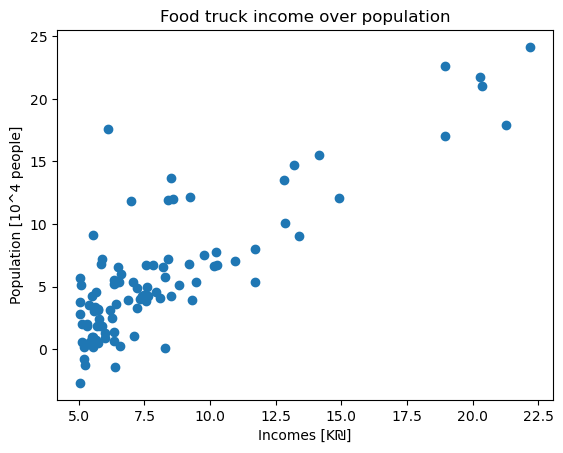

In [13]:
#create a scatter plot of tip vs total_bill
x = ex1_df[0]
y = ex1_df[1]
plt.scatter(x, y)

# add labels to the plot
plt.xlabel("Incomes [K₪]")
plt.ylabel("Population [10^4 people]")
plt.title("Food truck income over population")

GD_EX1 test - J(Θ) over number of iterations graphs for different learning rates

Caught exception for learning rate of: 1000.
Message: Cost function ascending detected!
New cost: 140.370588449862, Last cost: 0.023914315468629172

Caught exception for learning rate of: 100.
Message: Cost function ascending detected!
New cost: 1.094268096479397, Last cost: 0.023914315468629172



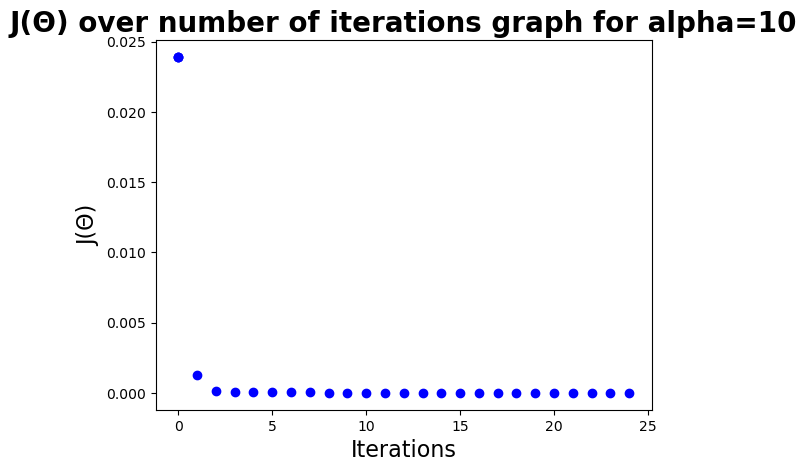

GD weights: [[1.2407012 ]
 [1.23805538]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 10
Θ0 error: 0.51%
Θ1 error: 0.29%


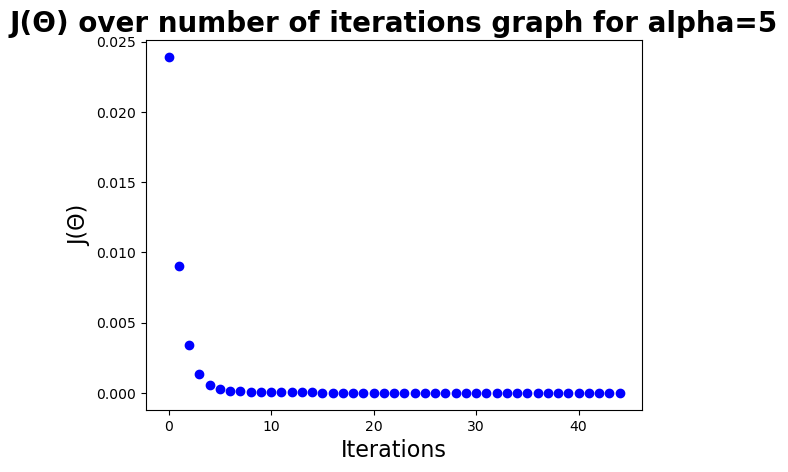

GD weights: [[1.24391004]
 [1.23990655]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 5
Θ0 error: 0.77%
Θ1 error: 0.44%


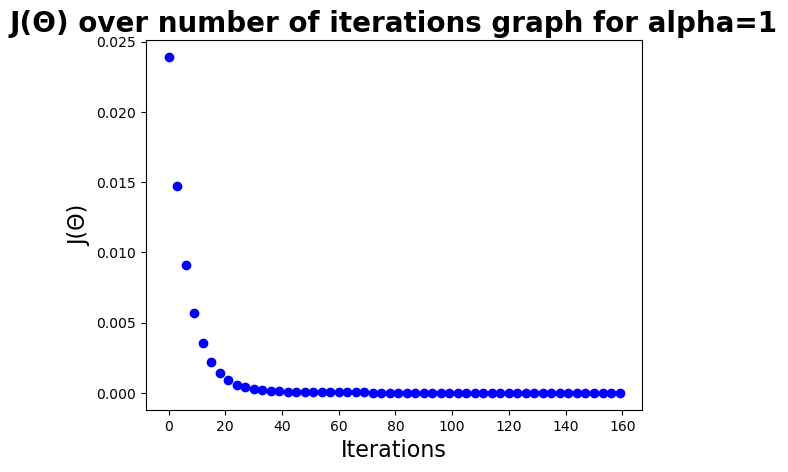

GD weights: [[1.25675243]
 [1.24731734]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 1
Θ0 error: 1.81%
Θ1 error: 1.04%


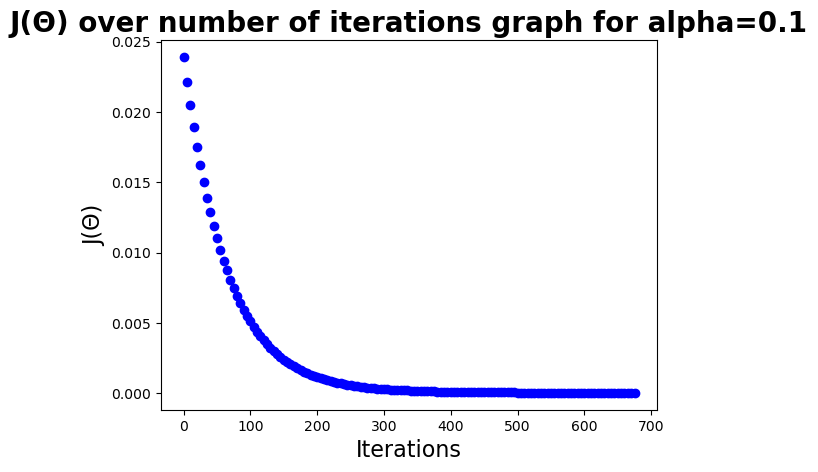

GD weights: [[1.30096203]
 [1.27722982]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 0.1
Θ0 error: 5.39%
Θ1 error: 3.47%


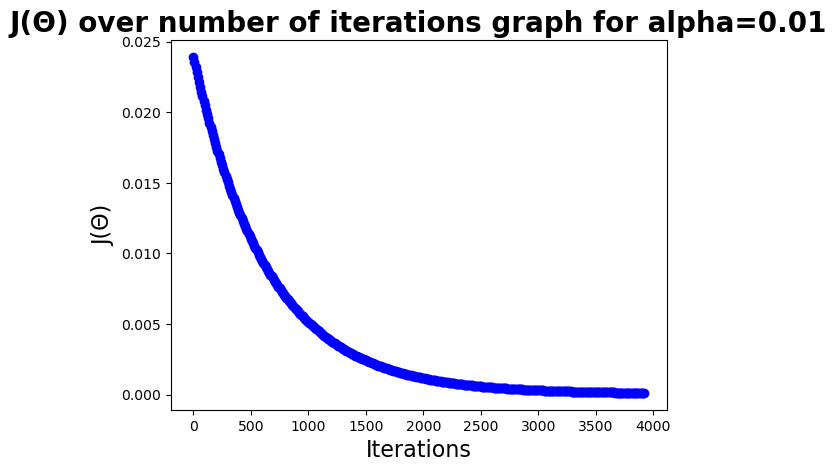

GD weights: [[1.3129816 ]
 [1.32207389]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 0.01
Θ0 error: 6.36%
Θ1 error: 7.1%


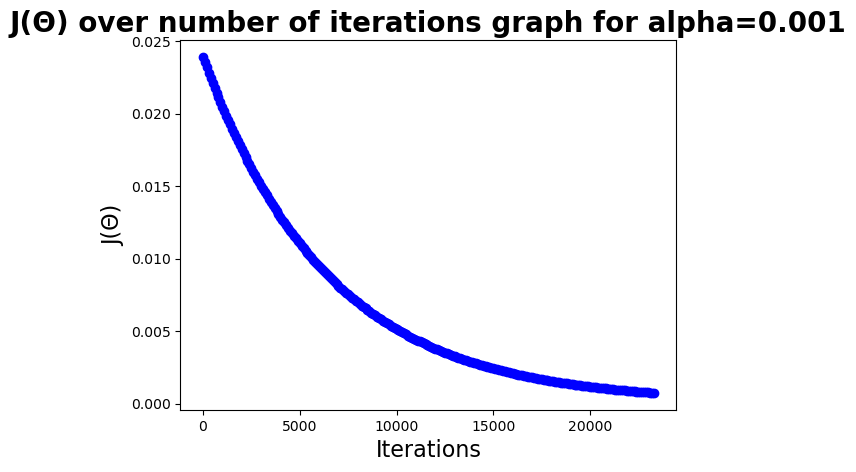

GD weights: [[1.28850141]
 [1.41179129]]

NE weights: [[1.23444787]
 [1.23444787]]

Errors for learning rate [alpha]: 0.001
Θ0 error: 4.38%
Θ1 error: 14.37%


In [14]:
configuration = [(1000, 10), (100, 10), (10, 1), (5, 1), (1, 3), (0.1, 5), (0.01, 10), (0.001, 100)]
fig_num = 1

for alpha, plot_res in configuration:
    try:
        weights = np.array([[1],[2]])
        plt.figure(fig_num)
        gd_weights = Utils.GD_EX1(weights=weights, 
                                    dataset=ex1_df, 
                                    alpha=alpha,
                                    plot_cost_iterations=True,
                                    plot_resolution=plot_res)
        plt.show()
        fig_num+=1
        
        ne_weights = Utils.normal_equation(ex1_df)
        weights_zipped = list(zip(gd_weights, ne_weights))
        error = list(map(lambda w: np.round((abs((w[0]-w[1])/w[1]))*100, 2), weights_zipped))

        print(f'GD weights: {gd_weights}\n')
        print(f'NE weights: {ne_weights}\n')

        print(f'Errors for learning rate [alpha]: {alpha}')
        for i in range(0,len(error)):
            msg = f'Θ{i} error: {error[i][0]}%'
            print(msg)
    except Exception as e:
        err_msg = f'Caught exception for learning rate of: {alpha}.\n' +\
                  f'Message: {e}\n'
        print(err_msg)

Plots of cost functions (contur and 3D graphs)

Text(0.5, 0.92, 'J(Θ) 3D surface')

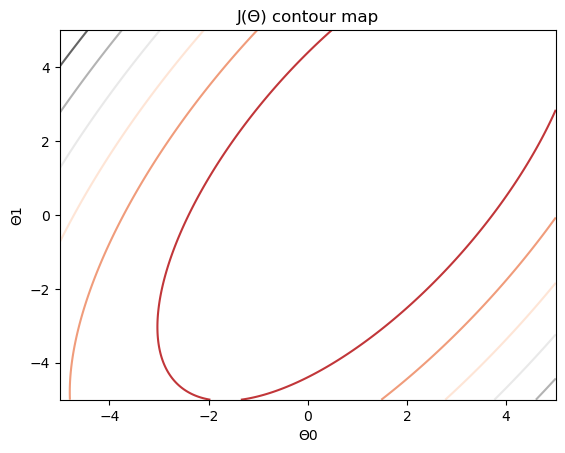

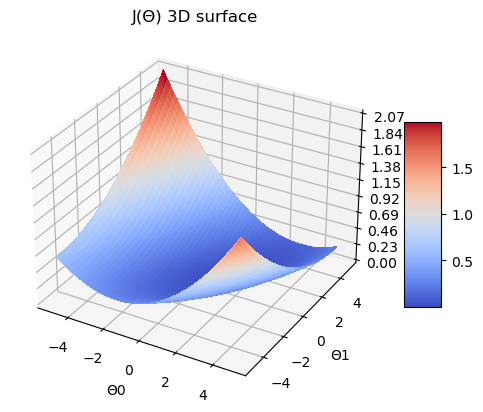

In [26]:
theta0 = np.linspace(-10, 10, 1000)
theta1 = np.linspace(-10, 10, 1000)

cost = []
for i in range(0, len(theta0)):
    for j in range(0, len(theta1)):
        weights = [[theta0[i]], [theta1[j]]]
        cost.append(Utils.calc_cost(weights, ex1_df))

t0_msh, t1_msh = np.meshgrid(theta0 ,theta1)
cost = np.array(cost).reshape(t0_msh.shape)

plt.contour(t0_msh, t1_msh, np.array(cost), cmap='RdGy')
plt.xlabel("Θ0")
plt.ylabel("Θ1")
plt.title("J(Θ) contour map")

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(t0_msh, t1_msh, cost, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel("Θ0")
plt.ylabel("Θ1")
plt.title("J(Θ) 3D surface")